In [190]:
from system import *
from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

In [121]:
# total_history = pd.DataFrame()
# with open("filtered_tickers.txt", "r") as src:
#     filtered_tickers = src.read().split("\n")

# for ticker in filtered_tickers[0:3]:
#     dqn_agent = DQN()
#     e_train = DQN.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
#     e_test = DQN.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
#     for i in range(5):
#         h_train = dqn_agent.run_episode(e_train)
#         h_train['mode'] = 'train'
#         h_train['t'] = range(len(h_train))
#         h_train['episode'] = int(i + 1)
#         total_history = pd.concat([total_history, h_train])
    
#     h_test = dqn_agent.run_episode(e_test)
#     h_test['mode'] = 'test'
#     h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
#     total_history = pd.concat([total_history, h_test])

# dqn_agent.train(num_tickers=1, episodes_per_ticker=100)

# Generating Experimental Data

In [191]:
total_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")

# agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
for A in agents:
    for ticker in tqdm(filtered_tickers[0:6]):
        a = A()
        e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        for i in range(7):
            h_train = a.run_episode(e_train)
            h_train['mode'] = 'train'
            h_train['t'] = range(len(h_train))
            h_train['episode'] = int(i + 1)
            h_train['agent'] = a.name
            total_history = pd.concat([total_history, h_train])

        h_test = a.run_episode(e_test)
        h_test['mode'] = 'test'
        h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
        h_test['agent'] = a.name
        total_history = pd.concat([total_history, h_test])
        
    

  0%|          | 0/6 [00:26<?, ?it/s]


ValueError: expected sequence of length 70 at dim 2 (got 1)

In [185]:
total_history

,date,ticker,rewards,actions,returns,prices,mode,t,episode,agent
Date,,,,,,,,,,
2014-01-06,2014-01-06,A,0.000000,0.0,0.000000,40.515022,train,0,1.0,Deep Q-Network
2014-01-07,2014-01-07,A,-0.891687,-1.0,-0.014299,41.094421,train,1,1.0,Deep Q-Network
2014-01-08,2014-01-08,A,0.065965,-1.0,-0.030426,41.766811,train,2,1.0,Deep Q-Network
2014-01-09,2014-01-09,A,-0.291882,-1.0,-0.030758,41.781116,train,3,1.0,Deep Q-Network
2014-01-10,2014-01-10,A,0.064118,-1.0,-0.039386,42.153076,train,4,1.0,Deep Q-Network
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ABC,0.425522,1.0,0.009470,70.760002,test,1251,NaN,Model-based
2018-12-26,2018-12-26,ABC,0.105633,1.0,0.010073,73.040001,test,1252,NaN,Model-based
2018-12-27,2018-12-27,ABC,0.099311,1.0,0.010202,73.529999,test,1253,NaN,Model-based


In [186]:
total_history['episode'].unique(), total_history['ticker'].unique()

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., nan]),
 array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC'], dtype=object))

In [187]:
training_history = total_history[(total_history['mode'] == 'train')]
training_history['discounted_reward'] = (training_history.t
                                             .apply( lambda x : np.power(dqn_agent.gamma, x))
                                            * training_history.rewards)
rewards_df = (
    training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'})
        .groupby(['agent', 'episode'])
        .agg({'discounted_reward' : 'mean'})
#          .plot()
)
rewards_df
# total_history[(total_history.ticker == 'A') & (total_history['mode'] == 'train')]
# h = total_history
# h[h.mode == 'train']

discounted_reward
agent          episode                   
A2C            1.0              -0.510811
               2.0               0.184859
               3.0               0.234289
               4.0               0.612919
               5.0               0.992610
               6.0               1.209040
               7.0               1.535479
DDPG           1.0               0.004163
               2.0               0.031751
               3.0               0.217931
               4.0               0.417751
               5.0               0.389329
               6.0               0.389424
               7.0               0.389355
Deep Q-Network 1.0               0.210427
               2.0               0.002401
               3.0              -0.087772
               4.0               0.122404
               5.0               0.396141
               6.0               0.416782
               7.0               0.334381
Model-based    1.0               1.145112
               2.0               0.785357
               3.0               1.004736
               4.0               1.022977
               5.0               1.242441
               6.0               1.682849
               7.0               1.260589

In [173]:
# rewards_df.reset_index(['agent', 'episode'], drop=False)

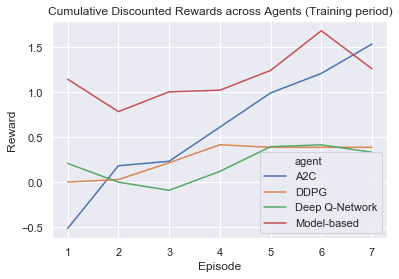

In [188]:
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=rewards_df.reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

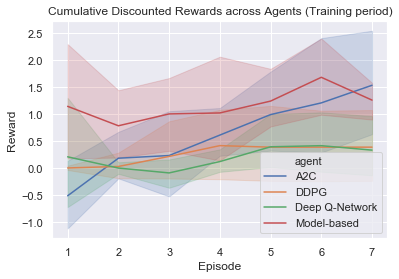

In [189]:
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'}).reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

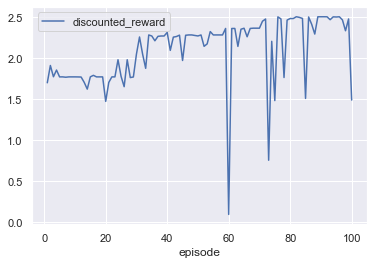

In [104]:
h = dqn_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot())

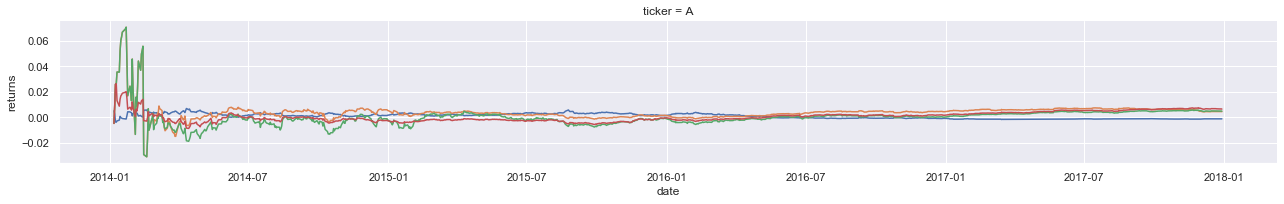

In [65]:
q = sns.FacetGrid(data=h[h.episode % 5 == 0], row='ticker', hue='episode', aspect=6, legend_out=True)
q.map(sns.lineplot, 'date', 'returns')

In [66]:
a2c_agent = A2C()
a2c_agent.train(num_tickers=1, episodes_per_ticker=20)

100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


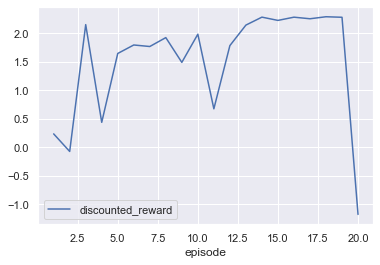

In [67]:
h = a2c_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
df.groupby(['ticker', 'episode']).agg({'discounted_reward' : 'sum'}).groupby('episode').agg({'discounted_reward' : 'mean'}).plot()

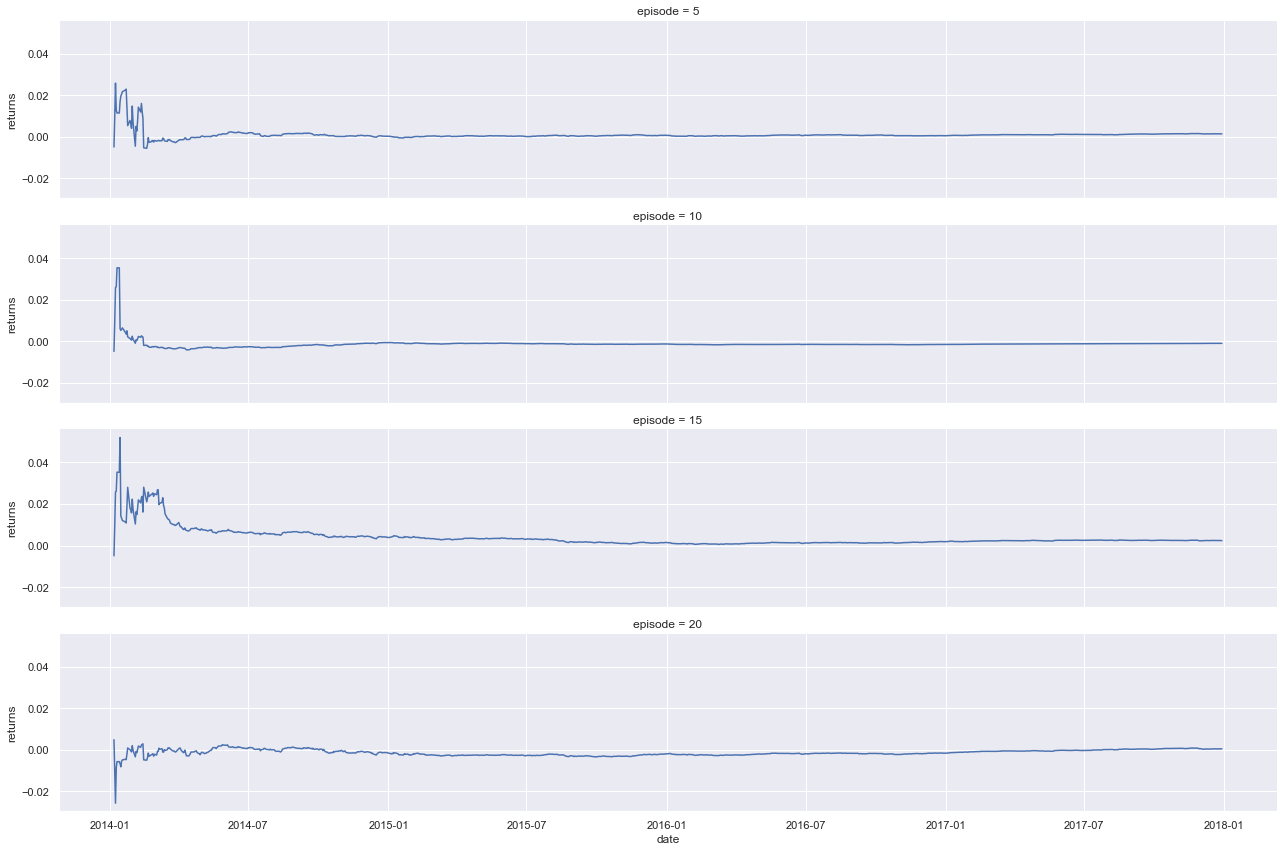

In [68]:
h = a2c_agent.history
q = sns.FacetGrid(data=h[h.episode % 5 == 0], row='episode', aspect=6, legend_out=True)
q.map(sns.lineplot, 'date', 'returns')

In [69]:
ddpg_agent = DDPG()
ddpg_agent.train(num_tickers=1, episodes_per_ticker=3)

100%|██████████| 3/3 [00:06<00:00,  2.22s/it]


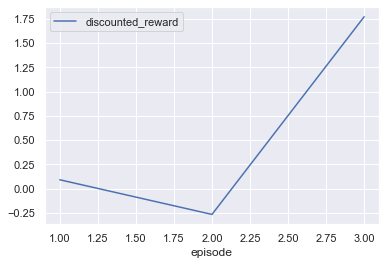

In [71]:
h = ddpg_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
df.groupby(['ticker', 'episode']).agg({'discounted_reward' : 'sum'}).groupby('episode').agg({'discounted_reward' : 'mean'}).plot()

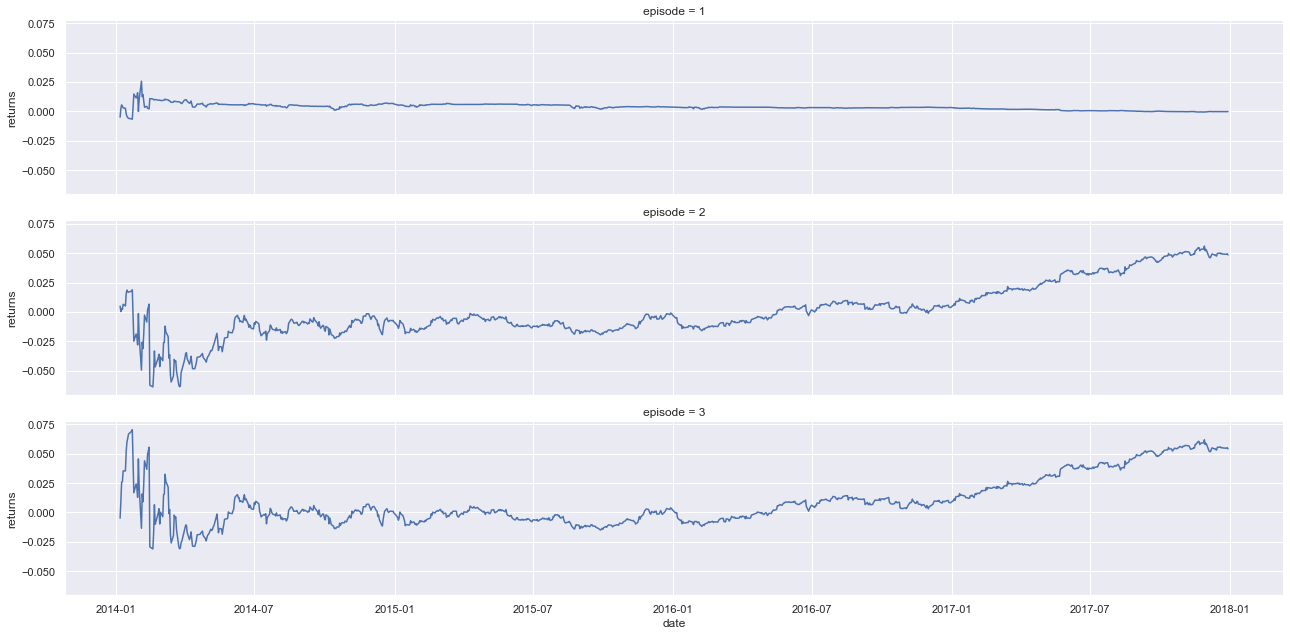

In [73]:
h = ddpg_agent.history
q = sns.FacetGrid(data=h, row='episode', aspect=6)
q.map(sns.lineplot, 'date', 'returns')

In [77]:
long_agent = LongOnlyAgent()
long_agent.train(num_tickers=1, episodes_per_ticker=3)

100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


In [101]:
h = long_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot())

KeyError: 't'

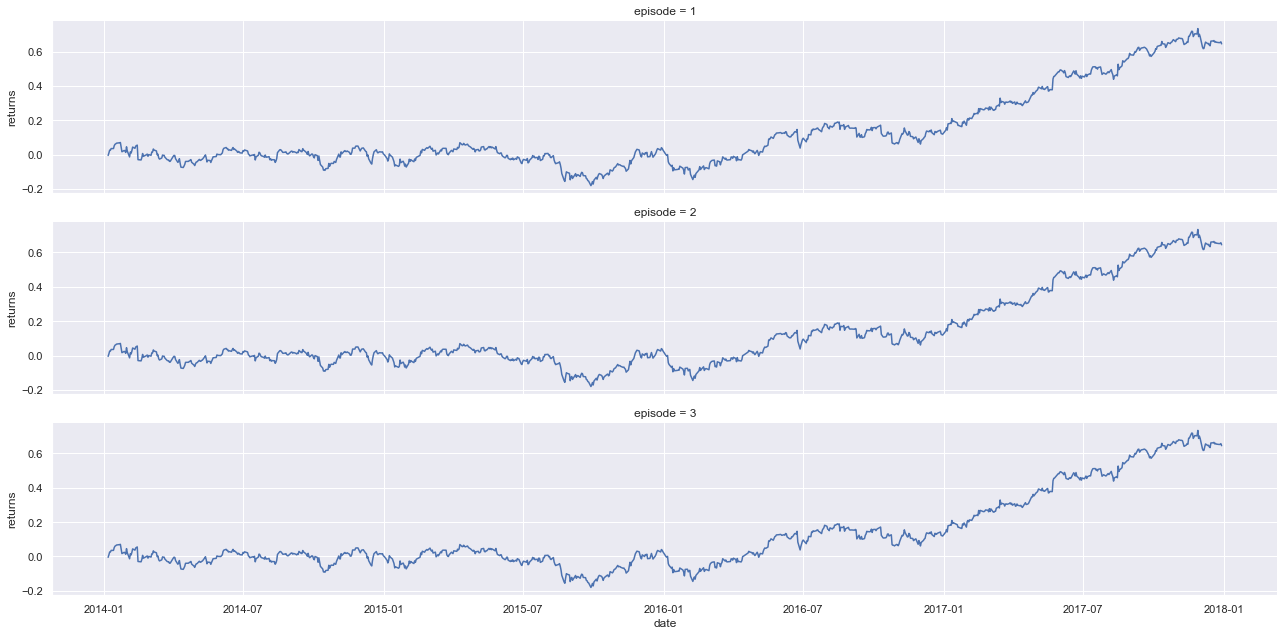

In [100]:
h = long_agent.history
q = sns.FacetGrid(data=h, row='episode', aspect=6)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
total_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")


In [97]:
for t in filtered_tickers:
    e_train = ModelBasedAgent.ENV_CONSTRUCTOR(t, mode='train')
    e_test  = ModelBasedAgent.ENV_CONSTRUCTOR(t, mode='test')
model_agent = ModelBasedAgent()
model_agent.train(num_tickers=1, episodes_per_ticker=)

100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


In [98]:
model_agent.history.head()

,date,ticker,rewards,actions,returns,prices,episode,t
0,2014-01-06,A,-9.944581,-1,0.004919,40.515022,1,0
1,2014-01-07,A,-8.919582,-1,-0.009451,41.094421,1,1
2,2014-01-08,A,0.659653,-1,-0.025657,41.766811,1,2
3,2014-01-09,A,-0.004213,0,-0.012995,41.781116,1,3
4,2014-01-10,A,0.646101,-1,-0.011643,42.153076,1,4


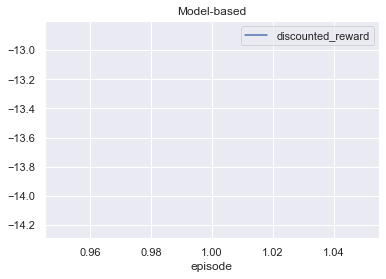

In [99]:
df = model_agent.history
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']

(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot(title=model_agent.name))

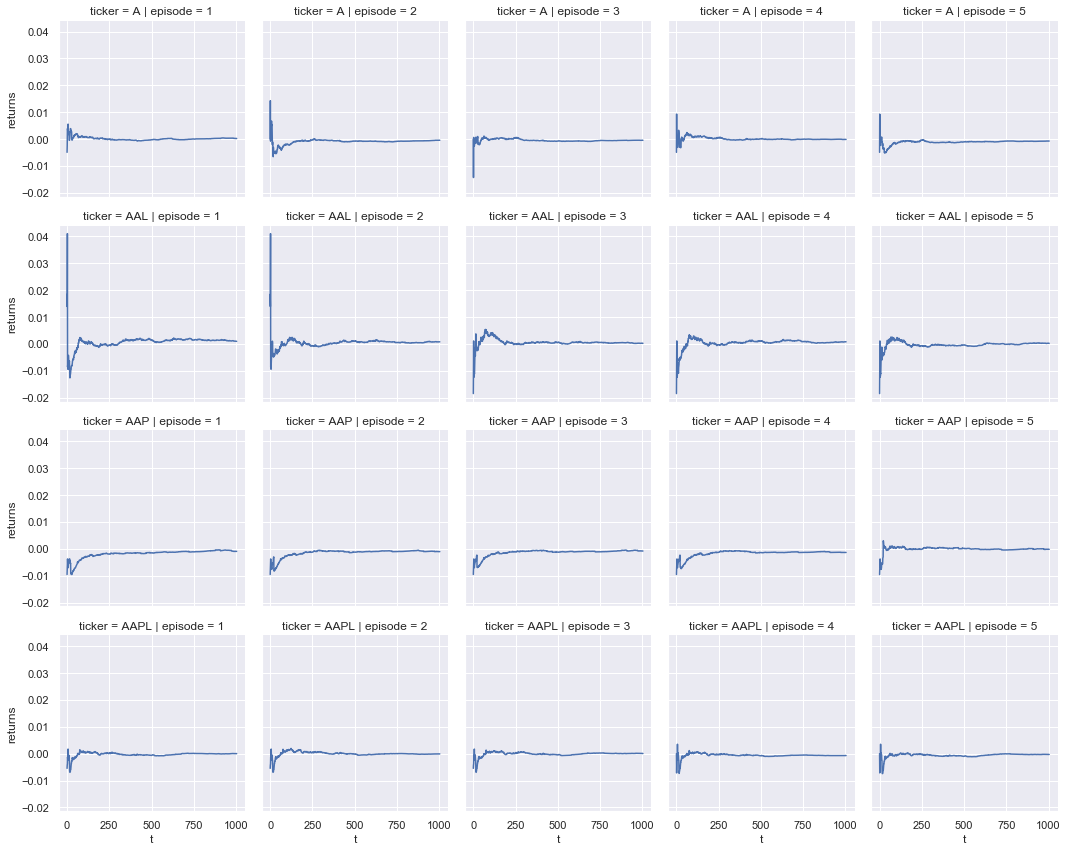

In [83]:
h = model_agent.history
q = sns.FacetGrid(data=h, col='episode', row='ticker')
q.map(sns.lineplot, 't', 'returns')

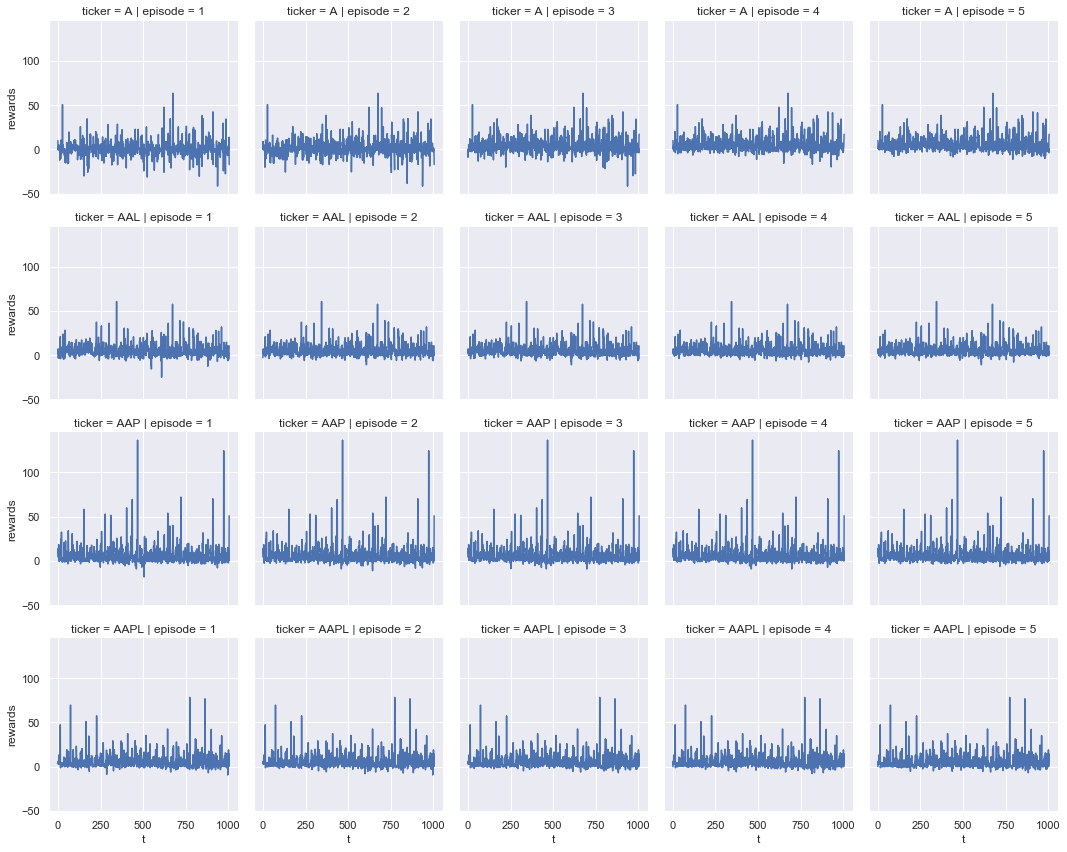

In [84]:
q = sns.FacetGrid(data=h, col='episode', row='ticker')
q.map(sns.lineplot, 't', 'rewards')

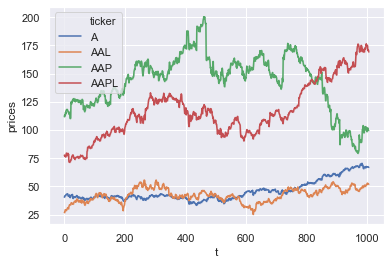

In [91]:
sns.lineplot('t', 'prices', hue='ticker', data=h)